In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, simps
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid.inset_locator import inset_axes
warnings.filterwarnings('ignore')

# DMO

In [15]:
simname = "HALO A"

In [93]:

pathsim = "/data/POL/HALOA/DMO/output_00020"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(pathsim)
zoomreg = np.where(myDMO.dm.mass==myDMO.dm.mass.min())
centro = nbe.real_center(myDMO.dm.pos3d[zoomreg],myDMO.dm.mass[zoomreg])

myDMO.center_shift(centro)
myDMO.r_virial(600,n=4)
myDMO.r200
myDMO.redefine(2.5)
print "recentering"
centro = nbe.real_center(myDMO.dm.pos3d[myDMO.dm.r<50],myDMO.dm.mass[myDMO.dm.r<50])
print centro
myDMO.center_shift(centro)
myDMO.r_virial(600,n=2.5)
myDMO.r200
myDMO.redefine(2.5)

loading Dark matter..
recentering
[-2.42378976 -0.00381113 -0.00387398]


In [94]:
"""
K = np.sum(myDMO.dm.mass*(myDMO.dm.v)**2)
print K
myGkm = 6.673e-11*(1e-3**3)*myDMO.p.msuntokg#km^ 3 Msun^-1 s^-2
r_sorted = np.argsort(myDMO.dm.r)
M_i = np.cumsum(myDMO.dm.mass[r_sorted]) - myDMO.dm.mass[r_sorted]
m_i = myDMO.dm.mass[r_sorted]
r_i = myDMO.dm.r[r_sorted]*(1e-2*myDMO.p.pctocm)# in km
U =  np.sum(-myGkm*M_i*m_i/r_i)
print U
print K/U + 1
"""

'\nK = np.sum(myDMO.dm.mass*(myDMO.dm.v)**2)\nprint K\nmyGkm = 6.673e-11*(1e-3**3)*myDMO.p.msuntokg#km^ 3 Msun^-1 s^-2\nr_sorted = np.argsort(myDMO.dm.r)\nM_i = np.cumsum(myDMO.dm.mass[r_sorted]) - myDMO.dm.mass[r_sorted]\nm_i = myDMO.dm.mass[r_sorted]\nr_i = myDMO.dm.r[r_sorted]*(1e-2*myDMO.p.pctocm)# in km\nU =  np.sum(-myGkm*M_i*m_i/r_i)\nprint U\nprint K/U + 1\n'

In [95]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


In [96]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

## Mass fit

In [97]:
Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]


print R_P03
hsml= 0.2# R_P03
print hsml,R_P03
# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO_in = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.


# R array logarithmic Bining
r_p = np.logspace(np.log10(3*hsml),np.log10(2.5*myDMO.r200),150)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r


Delta_rho = (myDMO.dm.mass.min() /vol) + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho2 = np.sqrt((myDMO.dm.mass.min()/np.sqrt(n_dm) /vol)**2 + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)**2)
Delta_rho3 =(4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho4 =(myDMO.dm.mass.min() /vol)

# extra estatistics from Cfalcon density
mean = std = n = stdlog = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myDMO.dm.r > r_p[i])&(myDMO.dm.r < r_p[i+1])&(myDMO.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myDMO.dm.rho[shell]))
    std = np.append(std,np.std(myDMO.dm.rho[shell]))
    stdlog = np.append(stdlog,np.std(np.log10(myDMO.dm.rho[shell])))
    
n_dm_bin = n
m_obs = n_dm*myDMO.dm.mass.min()
n = np.array([len(myDMO.dm.mass[myDMO.dm.r<i]) for i in r]) 
r_dmo_profile =r

1.0553507026327382
0.2 1.0553507026327382


In [98]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator



def chi2_mass_bin_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs)- np.log10(expected))
    c = c**2
    return np.sum(c)

def chi2_mass_bin(po,r_s,al,be,ga):
    """
    Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (m_obs - expected)/ (np.sqrt(n))
    c = c**2
    return np.sum(c)



def chi2_rho_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using mean of rho per shell
    """
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog
    c = c**2
    return np.sum(c)

def chi2_rho(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using mean of rho per shell
    """
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (rho_the - rho_obs)/ std
    c = c**2
    return np.sum(c)

In [99]:


m_rho = Minuit(chi2_rho_log, al=1., fix_al=True,
         po=7.0,    error_po=0.01,  limit_po =(2.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         be=3.,     error_be=0.1,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.1,   limit_ga =(.5,1.5))
m_rho.migrad();
chirhorho = chi2_rho_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
chibinrho= chi2_mass_bin_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 1.78372628122 
 TOTAL NCALL = 326 
 NCALLS = 326 
 
 
 EDM = 0.000118778853872 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.96963 
 0.382337 
 0 
 0 
 2.0 
 11.0 
 
 
 
 
 2 
 r_s 
 18.0728 
 9.04915 
 0 
 0 
 1.0 
 30.0 
 
 
 
 
 3 
 al 
 1 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 4 
 be 
 2.81517 
 0.282784 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 0.929251 
 0.130923 
 0 
 0 
 0.5 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.970e+00 & 3.823e-01 & & & 2.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 1.807e+01 & 9.049e+00 & & & 1.000e+00 & 3.000e+01 & \\
\hline
3 & al & 1.000e+00 & 1.000e+00 & & & & & FIXED\\
\hline
4 & be & 2.815e+00 & 2.828e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 9.293e-01 & 1.309e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 1.78, chi_bin = 0.22


In [100]:
m_bin = Minuit(chi2_mass_bin_log, al=1., fix_al=True,
         po=5.0,    error_po=0.01,  limit_po =(4.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         be=3.,     error_be=0.01,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.01,   limit_ga =(.5,1.5))
m_bin.migrad();

chirhobin = chi2_rho_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
chibinbin= chi2_mass_bin_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)

FCN = 0.218360841509 
 TOTAL NCALL = 291 
 NCALLS = 291 
 
 
 EDM = 3.37883519073e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.89156 
 1.41202 
 0 
 0 
 4.0 
 11.0 
 
 
 
 
 2 
 r_s 
 20.1351 
 22.5718 
 0 
 0 
 1.0 
 30.0 
 
 
 
 
 3 
 al 
 1 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 4 
 be 
 2.86045 
 0.679726 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 0.954675 
 0.719652 
 0 
 0 
 0.5 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.892e+00 & 1.412e+00 & & & 4.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 2.014e+01 & 2.257e+01 & & & 1.000e+00 & 3.000e+01 & \\
\hline
3 & al & 1.000e+00 & 1.000e+00 & & & & & FIXED\\
\hline
4 & be & 2.860e+00 & 6.797e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 9.547e-01 & 7.197e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 1.83, chi_bin = 0.22


In [101]:
#polfit
chirhopol = chi2_rho_log(7.663,5.552,1,2.636,0.819)
chibinpol= chi2_mass_bin_log(7.663,5.552,1,2.636,0.819)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 123.02, chi_bin = 13.76


<IPython.core.display.Javascript object>


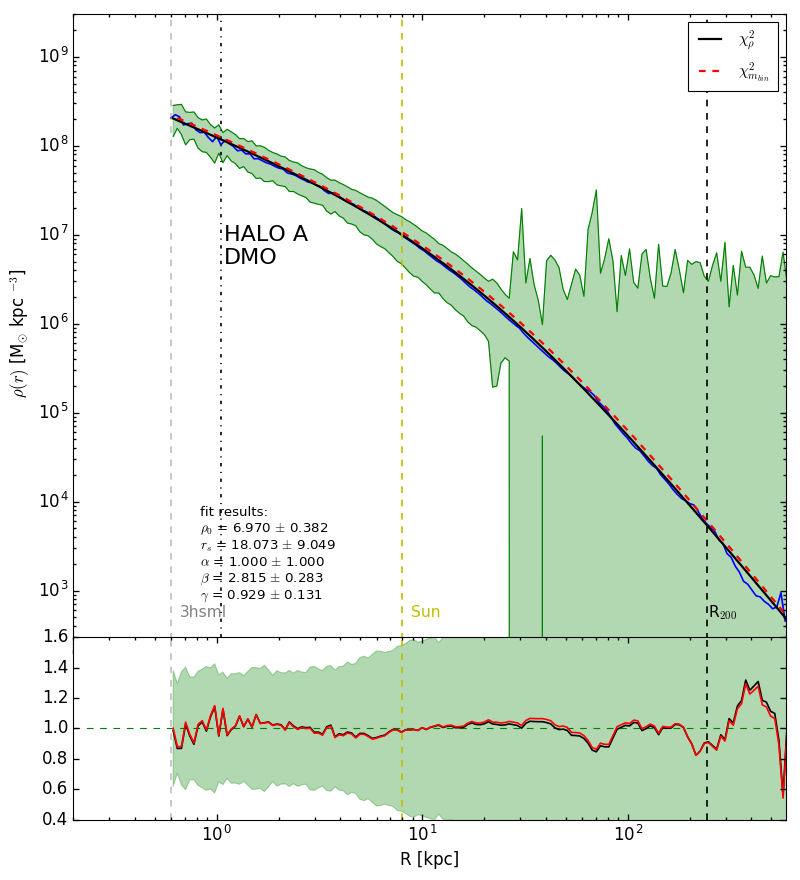

In [102]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},figsize=[10,11],sharex=True)
ax.set_xlim([hsml,2.4*myDMO.r200])
ax1.set_xlim([hsml,2.4*myDMO.r200])
ax1.set_ylim([.4,1.6])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)


#define sigma pluss and sigma minus lines
mean_plus = profileDMO+std
mean_minu = profileDMO-std

#  plot things
#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)
#ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std,alpha=0.5)

#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profileDMO,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k",lw=2,label=r"$\chi^2_{\rho}$")
## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax.plot(r[1:],(abg_profile(r[:-1],m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])),
        "r--",lw=2,label=r"$\chi^2_{m_{bin}}$ ")

texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["po"],m_rho.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["r_s"],m_rho.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["al"],m_rho.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["be"],m_rho.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["ga"],m_rho.errors["ga"])+"\n"
fig.text(0.28,0.7,simname+"\nDMO",fontsize=20)
fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,5e2,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,5e2,"Sun",color='y',fontsize=14)
ax.text(myDMO.r200*1.01,5e2,r"R$_{200}$",color='k',fontsize=14)
r_dm = r


#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
ax.axvline(x=R_P03,c='k',linestyle='-.',lw=1.5) #power radius
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myDMO.r200),100)
ax1.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO,
        "k",lw=1.5,label=r"$\chi^2(\rho) ")

ax1.plot(r_in,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO_in,
        "k--",lw=1.5,label=r"$\chi^2(\rho) ")
## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax1.fill_between(r,mean_plus/profileDMO,mean_minu/profileDMO,color="g",alpha=0.3)
ax1.plot(r,(abg_profile(r,m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga']))/profileDMO,
        "r-",lw=1.5)
ax1.plot(r_in,(abg_profile(r_in,m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga']))/profileDMO_in,
        "r--",lw=1.5)

#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200


legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
# layout
fig.tight_layout(h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/HaloBdmoprofile.png",dpi=300)

In [90]:
#### TAKES TIME ####

myGkpc = 6.673e-11*((1e-3/myDMO.p.kpctokm)**3)*myDMO.p.msuntokg#kpc^ 3 Msun^-1 s^-2
pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)#*myDMO.p.kpctokm
#ok, acc, Phy = CF.getGravity(pos,myDMO.dm.mass,0.190,G=myGkpc)

In [91]:
"""
bin_num = 512

pot_sph, bins_pot = np.histogram(r2,bins=bin_num,
                                 weights=Phy)
n, _ = np.histogram(r2,bins=bin_num)

bin_num = 512
bins_pot = np.linspace(0.,myDMO.dm.r.max(),512)
pot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<myDMO.r200**2)], bins=bin_num, weights=Phy[(r2<myDMO.r200**2)])
rmax = np.sqrt(bins_pot[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()])[0]
pot_max = (pot_sph/n)[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()][0]
"""

'\nbin_num = 512\n\npot_sph, bins_pot = np.histogram(r2,bins=bin_num,\n                                 weights=Phy)\nn, _ = np.histogram(r2,bins=bin_num)\n\nbin_num = 512\nbins_pot = np.linspace(0.,myDMO.dm.r.max(),512)\npot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<myDMO.r200**2)], bins=bin_num, weights=Phy[(r2<myDMO.r200**2)])\nrmax = np.sqrt(bins_pot[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()])[0]\npot_max = (pot_sph/n)[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()][0]\n'

In [92]:
myDMO.p.Z


-5.893557553315887e-05

# Hydro

In [3]:
pathsim = "/data/POL/HALOA/Hydro/output_01274"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhydro = wkbl.Galaxy_Hound(pathsim)
ok,rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)
centro_rho = myhydro.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhydro.center_shift(centro_rho)
myhydro.r_virial(600,n=2.5)

loading Dark matter..
loading Stars..
loading Gas..
density [9878.753 9781.957 9758.197]
| r_200 = 254.88
| Diagonal matrix computed 
|    | 18, 0, 0|
| D =| 0, 15, 0|
|    | 0,  0, 3|


In [4]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)

## virial parameter q

In [5]:
"""
pos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))
mass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))
nbe.real_center(pos_bar,mass_bar)
pos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km
mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
r_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
r_sorted = np.argsort(r_par)
M_i = np.cumsum(mass[r_sorted])
m_i = mass[r_sorted]
r_i = r_par[r_sorted]
U_hydro = np.sum(-myG*M_i*m_i/r_i)
k_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg
m_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg
E_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass
E_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass
E_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass
K_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)
K_hydro / U_hydro +1
print "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_dm),np.sum(2*E_k_st),np.sum(2*E_k_gs))
"""

'\npos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))\nmass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))\nnbe.real_center(pos_bar,mass_bar)\npos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km\nmass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))\nr_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))\nr_sorted = np.argsort(r_par)\nM_i = np.cumsum(mass[r_sorted])\nm_i = mass[r_sorted]\nr_i = r_par[r_sorted]\nU_hydro = np.sum(-myG*M_i*m_i/r_i)\nk_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg\nm_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg\nE_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass\nE_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass\nE_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass\nK_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)\nK_hydro / U_hydro +1\nprint "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_d

## mass fit

In [6]:
Pcrit = myhydro.dm._p.rho_crit
Mdm = myhydro.dm.mass.min()
myradiuses = myhydro.dm.r[np.argsort(myhydro.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  myhydro.gs.hsml.min()

# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_in = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.



# R array logarithmic Bining
r_p = np.logspace(np.log10(2*hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_hydro = std_hydro = stdlog_hydro = n_hydro=np.array([])
for i in range(len(r_p)-1):
    shell_hydro = np.where((myhydro.dm.r > r_p[i])&(myhydro.dm.r < r_p[i+1])&(myhydro.dm.r > hsml))
    n_hydro = np.append(n_hydro,len(shell_hydro[0]))
    mean_hydro = np.append(mean_hydro,np.mean(myhydro.dm.rho[shell_hydro]))
    std_hydro = np.append(std_hydro,np.std(myhydro.dm.rho[shell_hydro]))
    stdlog_hydro = np.append(stdlog_hydro,np.std(np.log10(myhydro.dm.rho[shell_hydro])))

m_obs_hydro = n_hydro*myhydro.dm.mass.min()
n_hydro = np.array([len(myhydro.dm.mass[myhydro.dm.r<i]) for i in r]) 


1.0450269108300865


In [7]:


def chi2_mass_bin_hydro(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs_hydro)- np.log10(expected))
    c = c**2
    return np.sum(c)


def chi2_rho_hydro(po,r_s,al,be,ga):
    rho_obs = profilehydro
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog_hydro
    c = c**2
    return np.sum(c)

In [10]:
m_rho_hydro = Minuit(chi2_rho_hydro,
         po=5.0,    error_po=0.01,  limit_po =(2.,9.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         al=2.8,     error_al=0.1,   limit_al=(0.5,4),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_rho_hydro.migrad();
chirhorho = chi2_rho_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
chibinrho= chi2_mass_bin_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 2.6018124361 
 TOTAL NCALL = 666 
 NCALLS = 666 
 
 
 EDM = 2.55394536326e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.00027 
 0.178075 
 0 
 0 
 2.0 
 9.0 
 
 
 
 
 2 
 r_s 
 4.5405 
 0.607089 
 0 
 0 
 1.0 
 30.0 
 
 
 
 
 3 
 al 
 1.84734 
 0.579843 
 0 
 0 
 0.5 
 4.0 
 
 
 
 
 4 
 be 
 2.48628 
 0.125832 
 0 
 0 
 2.0 
 3.5 
 
 
 
 
 5 
 ga 
 0.139663 
 0.168147 
 0 
 0 
 0.0 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.000e+00 & 1.781e-01 & & & 2.000e+00 & 9.000e+00 & \\
\hline
2 & $r_{s}$ & 4.540e+00 & 6.071e-01 & & & 1.000e+00 & 3.000e+01 & \\
\hline
3 & al & 1.847e+00 & 5.798e-01 & & & 5.000e-01 & 4.000e+00 & \\
\hline
4 & be & 2.486e+00 & 1.258e-01 & & & 2.000e+00 & 3.500e+00 & \\
\hline
5 & ga & 1.397e-01 & 1.681e-01 & & & 0.000e+00 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 2.60, chi_bin = 0.26


In [11]:
m_binH = Minuit(chi2_mass_bin_hydro,
         po=7.0,    error_po=0.01,  limit_po =(6.,9.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,20),
         al=2.8,     error_al=0.1,   limit_al=(0.5,4),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_binH.migrad();
chirhobin = chi2_rho_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
chibinbin= chi2_mass_bin_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)


FCN = 0.189632634663 
 TOTAL NCALL = 393 
 NCALLS = 393 
 
 
 EDM = 7.45132841637e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.11532 
 2.27454 
 0 
 0 
 6.0 
 9.0 
 
 
 
 
 2 
 r_s 
 4.57412 
 4.55031 
 0 
 0 
 1.0 
 20.0 
 
 
 
 
 3 
 al 
 1.48707 
 2.15126 
 0 
 0 
 0.5 
 4.0 
 
 
 
 
 4 
 be 
 2.58343 
 0.465064 
 0 
 0 
 2.0 
 3.5 
 
 
 
 
 5 
 ga 
 0.0417566 
 0.952152 
 0 
 0 
 0.0 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.115e+00 & 2.275e+00 & & & 6.000e+00 & 9.000e+00 & \\
\hline
2 & $r_{s}$ & 4.574e+00 & 4.550e+00 & & & 1.000e+00 & 2.000e+01 & \\
\hline
3 & al & 1.487e+00 & 2.151e+00 & & & 5.000e-01 & 4.000e+00 & \\
\hline
4 & be & 2.583e+00 & 4.651e-01 & & & 2.000e+00 & 3.500e+00 & \\
\hline
5 & ga & 4.176e-02 & 9.522e-01 & & & 0.000e+00 & 1.500e+00 & \\
\hline
\end{tabular}

chi_rho = 3.17, chi_bin = 0.19


In [12]:
#polfit
chirhopol = chi2_rho_hydro(7.663,4.425,2.895,2.541,8e-9)
chibinpol= chi2_mass_bin_hydro(7.663,4.425,2.895,2.541,8e-9)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 821.77, chi_bin = 14.77


<IPython.core.display.Javascript object>


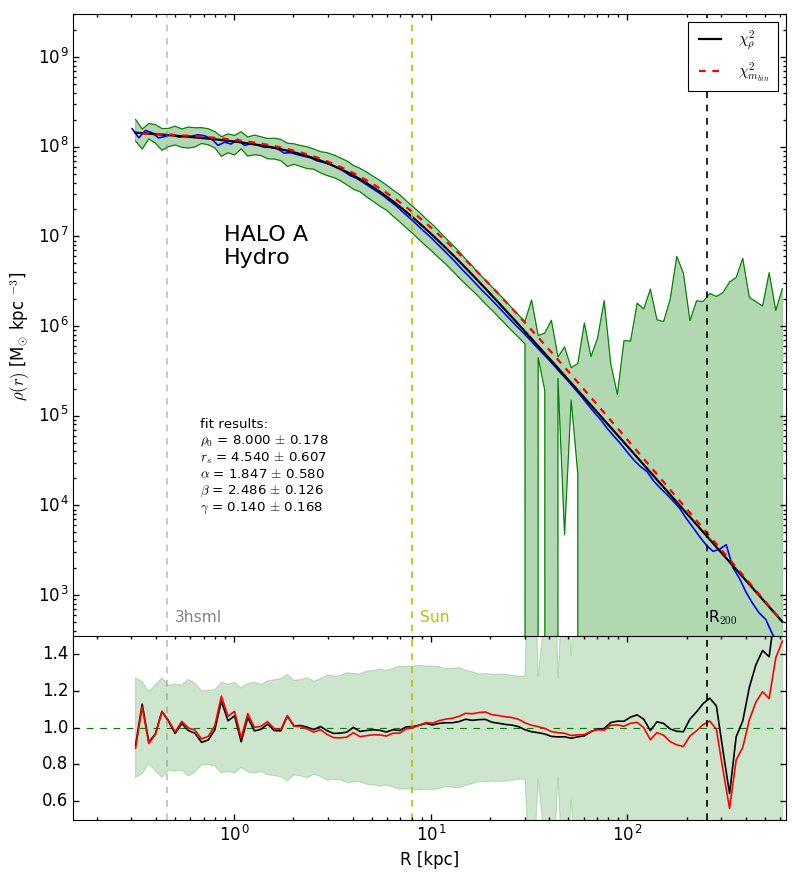

In [16]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},sharex=True,figsize=[10,11])
ax.set_xlim([hsml,2.5*myhydro.r200])
ax1.set_xlim([hsml,2.5*myhydro.r200])
ax1.set_ylim([.5,1.5])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)


#define sigma pluss and sigma minus lines
mean_plus = profilehydro+std_hydro
mean_minu = profilehydro-std_hydro
#ax.plot(r_dmo_profile,(abg_profile(r_dmo_profile,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
#        "k-.",lw=2,alpha=1,label='DMO')
#  plot things
#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)
#ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std,alpha=0.5)

#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profilehydro,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "k",lw=2,label=r"$\chi^2_{\rho}$")

## shell mass
ax.plot(r[1:],(abg_profile(r[:-1],m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])),
        "r--",lw=2,label=r"$\chi^2_{m_{bin}}$ ")

texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["po"],m_rho_hydro.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["r_s"],m_rho_hydro.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["al"],m_rho_hydro.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["be"],m_rho_hydro.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["ga"],m_rho_hydro.errors["ga"])+"\n"
fig.text(0.28,0.7,simname+"\nHydro",fontsize=20)
fig.text(0.25,0.4,texto,fontsize=12)
ax.text(3*hsml*1.1,5e2,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,5e2,"Sun",color='y',fontsize=14)
ax.text(myhydro.r200*1.01,5e2,r"R$_{200}$",color='k',fontsize=14)
r_dm = r

#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myhydro.r200),100)
ax1.plot(r,(abg_profile(r,m_rho_hydro.values['po'],m_rho_hydro.values['r_s'],
                          m_rho_hydro.values['al'],m_rho_hydro.values['be'],
                          m_rho_hydro.values['ga']))/profilehydro,
        "k",lw=1.5,label=r"$\chi^2(\rho) ")


## spehere mass
#ax.plot(r,(abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])),
#        "r-",lw=2)
## shell mass
ax1.fill_between(r,mean_plus/profilehydro,mean_minu/profilehydro,color="g",alpha=0.2)

ax1.plot(r,(abg_profile(r,m_binH.values['po'],m_binH.values['r_s'],
                          m_binH.values['al'],m_binH.values['be'],
                          m_binH.values['ga']))/profilehydro,
        "r-",lw=1.5)
ax1.plot(r_in,(abg_profile(r_in,m_binH.values['po'],m_binH.values['r_s'],
                                m_binH.values['al'],m_binH.values['be'],
                                m_binH.values['ga']))/profilehydro_in,
        "r--",lw=1.5)

#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200

############
"""
inax = fig.add_axes([0.26,0.4,0.25,0.25],axisbg='w')
inax.set_xlabel('r [kpc]', fontsize=14)
inax.set_ylabel(r'$ln(\rho)/ln(r)$', fontsize=25)
inax.set_xscale('log')
inax.set_ylim([-3,1])
inax.set_xlim([0.2,30])
x = np.log(r_p[valid])
y = np.log(profilehydro[valid])#/np.log(r_p[valid])
dy = np.gradient(y)
dx = np.gradient(x)
dlnp = np.gradient(np.log(abg_profile(r_p[valid],m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])))
dlnr = np.gradient(np.log(r_p[valid]))
inax.plot(r_p[valid],dy/dx,'g',lw=1.5)
inax.plot(r_p[valid],dlnp/dlnr,'r',lw=2)
inax.axhline(y=-m_binH.values['ga'],color='gray',linestyle='--',linewidth=2)
inax.text(3,0,"$\gamma$ = "+"{0:.3f}".format(-m_binH.values['ga']))
"""
# layout
fig.tight_layout(h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/HaloBhydroprofile.png",dpi=300)
##########################################################################################
##########################################################################################


In [17]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "##################  DM profile ####################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
##################  DM profile ####################
fit results: 
$\rho_0$ = 8.000 $\pm$ 0.178
$r_s$ = 4.540 $\pm$ 0.607
$\alpha$ = 1.847 $\pm$ 0.580
$\beta$ = 2.486 $\pm$ 0.126
$\gamma$ = 0.140 $\pm$ 0.168



In [18]:
def my_int(Ri,Rf,po,r_s,al,be,ga):
    r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
    rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
    return 4* np.pi * simps(rho_test,r_test)

print "integrated mass fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga']))
print "integrates rho fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga']))
print "mass inside r200 = {0:1.3e}".format(myhydro.dm.mass[(myhydro.dm.r>hsml)&(myhydro.dm.r<myhydro.r200)].sum())


integrated mass fit = 1.529e+12
integrates rho fit = 1.491e+12
mass inside r200 = 1.509e+12


# Stars 

In [19]:
ok,myhydro.st.rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)

In [20]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(12),stars_bins)
yedges = np.linspace(-1.,1.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = sigma_log_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhydro.st.R >= xedges[i] )&(myhydro.st.R < xedges[i+1] )
        Zcon = (myhydro.st.pos3d[:,2] >= yedges[j])&(myhydro.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhydro.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(myhydro.st.rho[np.where(Rcon&Zcon)])
        sigma_log_st[j][i] = np.std(np.log10(myhydro.st.rho[np.where(Rcon&Zcon)]))
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


In [22]:
def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    c = ((observed) - (expected))
    c = c**2
    return np.nansum(c)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.st.mass[np.where((myhydro.st.R<50.)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

<IPython.core.display.Javascript object>


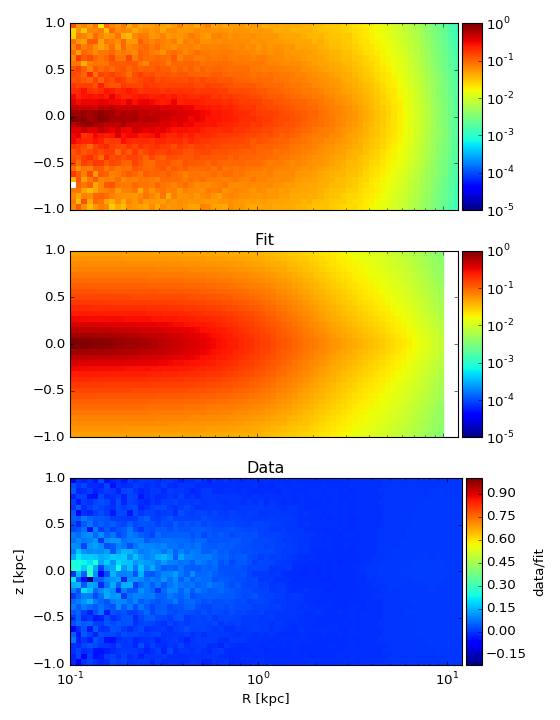

In [23]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

U= np.meshgrid(x, y)



Z = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,
                    8, 0.5, 2.8,
                    8, 1.3 ,5.1)




fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

ax1.set_title("Fit")
ax1.set_xscale('log')

fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))#/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

In [24]:
"""
Z = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,
                    8, 0.6, 3.1,
                    8, 1.3 ,6.1)

"""

'\nZ = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,\n                    8, 0.6, 3.1,\n                    8, 1.3 ,6.1)\n\n'

In [32]:
m1=Minuit(chi2_st, 
         B_0=9.6,    fix_B_0=True,#error_B_0=0.5,     limit_B_0=(9,10),
         r0=0.8,    error_r0=0.1,     limit_r0=(0.01,2),
         al=1.6,     error_al=0.1,    limit_al=(0,5.),
         r_cut=1.5,  error_r_cut=0.1,   limit_r_cut=(1,9.),
         q=0.5,      error_q=0.1,     limit_q=(0,1.),
         d_0=8.7,    fix_d_0=True,#error_d_0=0.5,     limit_d_0=(7,10.5),
         z_d=.4,     error_z_d=0.2,  limit_z_d=(0.,1.),
         Rd=1.5,     error_Rd=0.01,        limit_Rd=(1.,9.0),
         D_0=7.8,    fix_D_0=True,#error_D_0=0.5,     limit_D_0=(7.,10.5),
         z_D=1.1,    error_z_D=0.02,  limit_z_D=(0.7,2.9),
         RD=1.9,     error_RD=0.01,        limit_RD=(5,9.)
         )
m1.migrad();

err = 4
upp = 1.7
low = 0.
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], fix_B_0=True,#error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], fix_d_0=True,#error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], fix_D_0=True,#error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();


FCN = 5.10380796252e+21 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 0.0 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 9.6 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 2 
 r0 
 0.8 
 1.38935 
 0 
 0 
 0.01 
 2.0 
 
 
 
 
 3 
 al 
 1.6 
 3.2721 
 0 
 0 
 0.0 
 5.0 
 
 
 
 
 4 
 r_cut 
 1.5 
 4.5207 
 0 
 0 
 1.0 
 9.0 
 
 
 
 
 5 
 q 
 0.5 
 0.746941 
 0 
 0 
 0.0 
 1.0 
 
 
 
 
 6 
 d_0 
 8.7 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 7 
 z_d 
 0.4 
 0.699749 
 0 
 0 
 0.0 
 1.0 
 
 
 
 
 8 
 Rd 
 1.5 
 4.5207 
 0 
 0 
 1.0 
 9.0 
 
 
 
 
 9 
 D_0 
 7.8 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 10 
 z_D 
 1.1 
 1.22365 
 0 
 0 
 0.7 
 2.9 
 
 
 
 
 11 
 RD 
 5 
 2.84213 
 0 
 0 
 5.0 
 9.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 9.600e+00 & 1.000e+00 & & & & & FIXED\\
\hline
2 & r0 & 8.000e-01 & 1.389e+00 & & & 1.000e-02 & 2.000e+00 & \\
\hline
3 & al & 1.600e+00 & 3.272e+00 & & & 0.000e+00 & 5.000e+00 & \\
\hline
4 & $r_{cut}$ & 1.500e+00 & 4.521e+00 & & & 1.000e+00 & 9.000e+00 & \\
\hline
5 & q & 5.000e-01 & 7.469e-01 & & & 0.000e+00 & 1.000e+00 & \\
\hline
6 & $d_{0}$ & 8.700e+00 & 1.000e+00 & & & & & FIXED\\
\hline
7 & $z_{d}$ & 4.000e-01 & 6.997e-01 & & & 0.000e+00 & 1.000e+00 & \\
\hline
8 & Rd & 1.500e+00 & 4.521e+00 & & & 1.000e+00 & 9.000e+00 & \\
\hline
9 & $D_{0}$ & 7.800e+00 & 1.000e+00 & & & & & FIXED\\
\hline
10 & $z_{D}$ & 1.100e+00 & 1.224e+00 & & & 7.000e-01 & 2.900e+00 & \\
\hline
11 & RD & 5.000e+00 & 2.842e+00 & & & 5.000e+00 & 9.000e+00 & \\
\hline
\end{tabular}

FCN = 5.37931919098e-06 
 TOTAL NCALL = 311 
 NCALLS = 311 
 
 
 EDM = 1.40356165272e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 9.6 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 2 
 r0 
 0.936055 
 5.00149e-07 
 0 
 0 
 0.0 
 1.36 
 
 
 
 
 3 
 al 
 0.000221145 
 6.6091e-11 
 0 
 0 
 0.0 
 2.72 
 
 
 
 
 4 
 r_cut 
 2.246 
 6.38356e-11 
 0 
 0 
 0.0 
 2.55 
 
 
 
 
 5 
 q 
 0.509659 
 4.67594e-11 
 0 
 0 
 0.0 
 0.85 
 
 
 
 
 6 
 d_0 
 8.7 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 7 
 z_d 
 0.446889 
 2.72354e-10 
 0 
 0 
 0.0 
 0.68 
 
 
 
 
 8 
 Rd 
 2.55 
 7.33771e-10 
 0 
 0 
 0.0 
 2.55 
 
 
 
 
 9 
 D_0 
 7.8 
 1 
 0 
 0 
 
 
 FIXED 
 
 
 
 10 
 z_D 
 1.21164 
 1.04433e-09 
 0 
 0 
 0.0 
 1.87 
 
 
 
 
 11 
 RD 
 5.40916 
 1.74562e-09 
 0 
 0 
 0.0 
 8.50000648498 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 9.600e+00 & 1.000e+00 & & & & & FIXED\\
\hline
2 & r0 & 9.361e-01 & 5.001e-07 & & & 0.000e+00 & 1.360e+00 & \\
\hline
3 & al & 2.211e-04 & 6.609e-11 & & & 0.000e+00 & 2.720e+00 & \\
\hline
4 & $r_{cut}$ & 2.246e+00 & 6.384e-11 & & & 0.000e+00 & 2.550e+00 & \\
\hline
5 & q & 5.097e-01 & 4.676e-11 & & & 0.000e+00 & 8.500e-01 & \\
\hline
6 & $d_{0}$ & 8.700e+00 & 1.000e+00 & & & & & FIXED\\
\hline
7 & $z_{d}$ & 4.469e-01 & 2.724e-10 & & & 0.000e+00 & 6.800e-01 & \\
\hline
8 & Rd & 2.550e+00 & 7.338e-10 & & & 0.000e+00 & 2.550e+00 & \\
\hline
9 & $D_{0}$ & 7.800e+00 & 1.000e+00 & & & & & FIXED\\
\hline
10 & $z_{D}$ & 1.212e+00 & 1.044e-09 & & & 0.000e+00 & 1.870e+00 & \\
\hline
11 & RD & 5.409e+00 & 1.746e-09 & & & 0.000e+00 & 8.500e+00 & \\
\hline
\end{tabular}

In [33]:

def mass_integrated(edge,B0,d0,D0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                    m2.values['q'], d0, m2.values['z_d'], m2.values['Rd'],
                                    D0, m2.values['z_D'], m2.values['RD'])

    def integrand(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], d0, m2.values['z_d'], m2.values['Rd'],D0, m2.values['z_D'], m2.values['RD']))
    
    F = i[0] #firs level fit
    return F 

get_masses = np.vectorize(mass_integrated)
get_mass_data = np.vectorize(lambda u :np.sum(myhydro.st.mass[np.where((myhydro.st.R<u)&(np.abs(myhydro.st.pos3d[:,2])<u/10.))]))


In [34]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
level1 = get_masses(r_masses,9.3,8.1,8.)
data_mass = get_mass_data(r_masses)

In [35]:
def chimass(B0,d0,D0):
    c = np.log10(get_masses(r_masses,B0,d0,D0))-np.log10(data_mass)
    return np.sum(c**2)


mmass=Minuit(chimass, 
         B0=9.5,  error_B0=0.5,     limit_B0=(7,10.7),
         d0=9.5,  error_d0=0.5,     limit_d0=(7,10.7),
         D0=9.5,  error_D0=0.5,     limit_D0=(7,10.7))
#         print_level=0)
mmass.migrad();

FCN = 0.00710566919348 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 5.42558403286e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B0 
 9.03826 
 2.62864 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 2 
 d0 
 8.93613 
 2.30283 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 3 
 D0 
 8.52931 
 0.746773 
 0 
 0 
 7.0 
 10.7 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & B0 & 9.038e+00 & 2.629e+00 & & & 7.000e+00 & 1.070e+01 & \\
\hline
2 & d0 & 8.936e+00 & 2.303e+00 & & & 7.000e+00 & 1.070e+01 & \\
\hline
3 & D0 & 8.529e+00 & 7.468e-01 & & & 7.000e+00 & 1.070e+01 & \\
\hline
\end{tabular}

In [36]:
level1 = get_masses(r_masses,mmass.values["B0"],mmass.values["d0"],mmass.values["D0"])

<IPython.core.display.Javascript object>


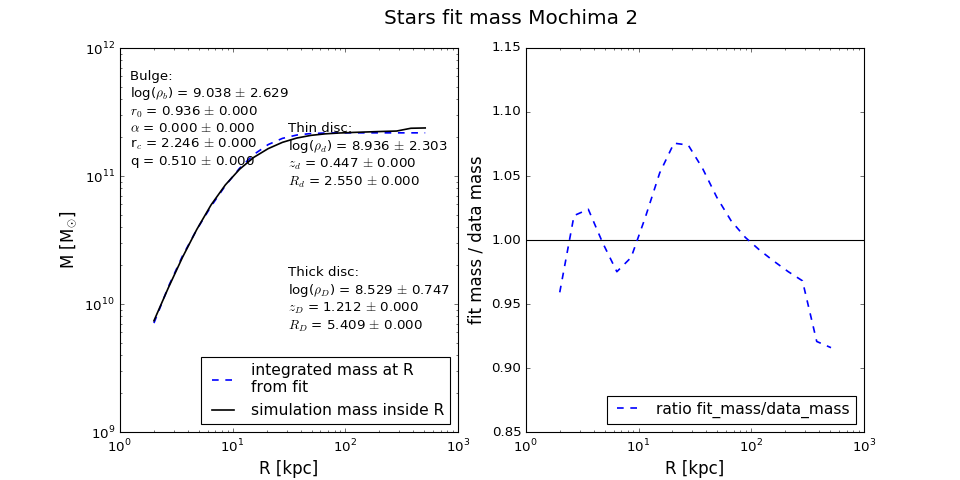

In [37]:
bulge = "Bulge: \n"
bulge += r"log($\rho _b$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["B0"],mmass.errors["B0"])+"\n"
bulge += r"$r_0$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r0"],m2.errors["r0"])+"\n"
bulge += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["al"],m2.errors["al"])+"\n"
bulge += r"r$_c$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r_cut"],m2.errors["r_cut"])+"\n"
bulge += r"q = {0:.3f} $\pm$ {1:.3f}".format(m2.values["q"],m2.errors["q"])+"\n"

thin_disc = "Thin disc: \n"
thin_disc += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["d0"],mmass.errors["d0"])+"\n"
thin_disc += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_d"],m2.errors["z_d"])+"\n"
thin_disc += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["Rd"],m2.errors["Rd"])+"\n"

thik_disc = "Thick disc: \n"
thik_disc += r"log($\rho _D$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["D0"],mmass.errors["D0"])+"\n"
thik_disc += r"$z_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_D"],m2.errors["z_D"])+"\n"
thik_disc += r"$R_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["RD"],m2.errors["RD"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Mochima 2",fontsize=18)
fig.text(0.135,0.62,bulge,fontsize=12)
fig.text(0.3,0.58,thin_disc,fontsize=12)
fig.text(0.3,0.28,thik_disc,fontsize=12)

ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim([0.85,1.15])
ax[0].plot(r_masses,level1,'b--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level1/data_mass,'b--',lw=1.5,label="ratio fit_mass/data_mass")
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
#frame = legend.get_frame()

In [38]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "#################### Stars ########################"

print bulge
print thin_disc
print thik_disc

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
#################### Stars ########################
Bulge: 
log($\rho _b$) = 9.038 $\pm$ 2.629
$r_0$ = 0.936 $\pm$ 0.000
$\alpha$ = 0.000 $\pm$ 0.000
r$_c$ = 2.246 $\pm$ 0.000
q = 0.510 $\pm$ 0.000

Thin disc: 
log($\rho _d$) = 8.936 $\pm$ 2.303
$z_d$ = 0.447 $\pm$ 0.000
$R_d$ = 2.550 $\pm$ 0.000

Thick disc: 
log($\rho _D$) = 8.529 $\pm$ 0.747
$z_D$ = 1.212 $\pm$ 0.000
$R_D$ = 5.409 $\pm$ 0.000



<IPython.core.display.Javascript object>


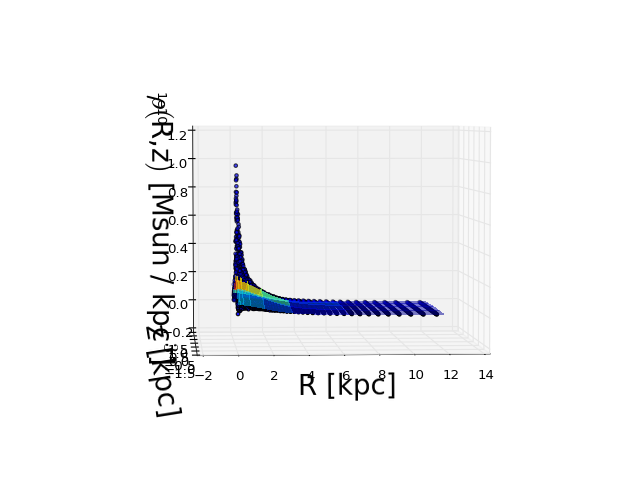

2346
2346
2346


In [39]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'],m2.values['z_D'], m2.values['RD'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zscale('log')
#ax.set_zlim([0,1.2])

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


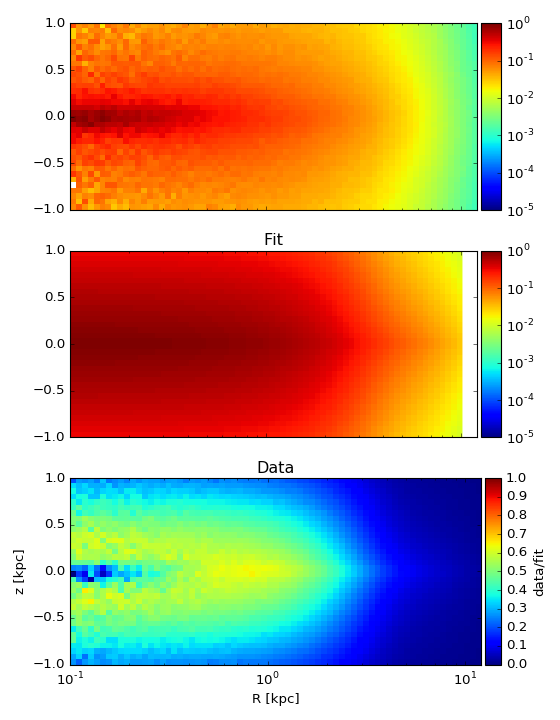

In [40]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)



Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],m2.values['q'],
          mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'], m2.values['z_D'], m2.values['RD'])




fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')



fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))#/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

# gas

In [41]:
log_hsml = np.log10(myhydro.gs.hsml.min())

In [42]:
gs_bins=40
edge = 20
zedge = edge/40.
x_gs = np.logspace(-0.5,np.log10(edge),gs_bins)
y_gs = np.linspace(-zedge,zedge,gs_bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhydro.gs.R >= x_gs[i] )&(myhydro.gs.R < x_gs[i+1] )
        Zcon = (myhydro.gs.pos3d[:,2] >= y_gs[j])&(myhydro.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhydro.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhydro.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


In [43]:
dens_hist_gs = np.nan_to_num(dens_hist_gs)

In [44]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

<IPython.core.display.Javascript object>

In [45]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2# / sigma_gs**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    xe, ye = np.linspace(0,edge,gs_bins ),np.linspace(-edge/15.,edge/15.,gs_bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    N = len(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))
    return  diff

In [46]:
mg1=Minuit(chi2_gas, 
           D_0=8.4,    error_D_0=0.7,     limit_D_0=(8.5,10.5),
           z_d=0.6,  error_z_d=0.1,  limit_z_d=(0.001,2),
           Rd=2.5,     error_Rd=0.1,        limit_Rd=(0.3,4))
mg1.migrad();

err = 0.01
upp = 1.5
low = 0.5
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = 1.07765264112e+22 
 TOTAL NCALL = 217 
 NCALLS = 217 
 
 
 EDM = 1859615874.44 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 10.5 
 0 
 0 
 0 
 8.5 
 10.5 
 
 
 
 
 2 
 z_d 
 0.0757254 
 1.67111e-12 
 0 
 0 
 0.001 
 2.0 
 
 
 
 
 3 
 Rd 
 0.33676 
 4.42055e-12 
 0 
 0 
 0.3 
 4.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 1.050e+01 & 0.000e+00 & & & 8.500e+00 & 1.050e+01 & \\
\hline
2 & $z_{d}$ & 7.573e-02 & 1.671e-12 & & & 1.000e-03 & 2.000e+00 & \\
\hline
3 & Rd & 3.368e-01 & 4.421e-12 & & & 3.000e-01 & 4.000e+00 & \\
\hline
\end{tabular}

FCN = 0.000245442933977 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = 0.0491209238478 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 11.1928 
 0.148354 
 0 
 0 
 5.25 
 15.75 
 
 
 
 
 2 
 z_d 
 0.0752851 
 0.0565475 
 0 
 0 
 0.0378627050334 
 0.1135881151 
 
 
 
 
 3 
 Rd 
 0.334185 
 0.130577 
 0 
 0 
 0.168380243971 
 0.505140731912 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 1.119e+01 & 1.484e-01 & & & 5.250e+00 & 1.575e+01 & \\
\hline
2 & $z_{d}$ & 7.529e-02 & 5.655e-02 & & & 3.786e-02 & 1.136e-01 & \\
\hline
3 & Rd & 3.342e-01 & 1.306e-01 & & & 1.684e-01 & 5.051e-01 & \\
\hline
\end{tabular}

In [47]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhydro.st.mass[np.where((myhydro.st.R<edge)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<u)&(np.abs(myhydro.gs.pos3d[:,2])<u/10.))]))


In [48]:
def mass_gas(edge,d0,zd,rd):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(d0,zd,rd))
    
    F = j[0] #firs level fit
    return F 

get_mass_GAs = np.vectorize(mass_gas)


In [54]:
r_masses = np.logspace(np.log10(2),np.log10(30),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

In [55]:
def chimass_gs(d0,zs,r0):
    c = np.log10(get_mass_GAs(r_masses,d0,zs,r0))-np.log10(gdata_mass)
    return np.sum(c**2)


mmass_gs=Minuit(chimass_gs, 
         d0=9,  error_d0=0.2,     limit_d0=(6,10.7),
         zs=.1,  error_zs=0.01,     limit_zs=(0.01,1.5),
         r0=3.5,  error_r0=0.1,     limit_r0=(1,8))
#         print_level=0)
mmass_gs.migrad();

FCN = 0.00924711149149 
 TOTAL NCALL = 269 
 NCALLS = 269 
 
 
 EDM = 0.000118665250341 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 d0 
 9.8726 
 4.28411 
 0 
 0 
 6.0 
 10.7 
 
 
 
 
 2 
 zs 
 0.0377852 
 1.06861 
 0 
 0 
 0.01 
 1.5 
 
 
 
 
 3 
 r0 
 1.90644 
 1.84742 
 0 
 0 
 1.0 
 8.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & d0 & 9.873e+00 & 4.284e+00 & & & 6.000e+00 & 1.070e+01 & \\
\hline
2 & zs & 3.779e-02 & 1.069e+00 & & & 1.000e-02 & 1.500e+00 & \\
\hline
3 & r0 & 1.906e+00 & 1.847e+00 & & & 1.000e+00 & 8.000e+00 & \\
\hline
\end{tabular}

In [56]:
gas_fit_from_mass = get_mass_GAs(r_masses,mmass_gs.values['d0'],mmass_gs.values['zs'],mmass_gs.values['r0'])

<IPython.core.display.Javascript object>


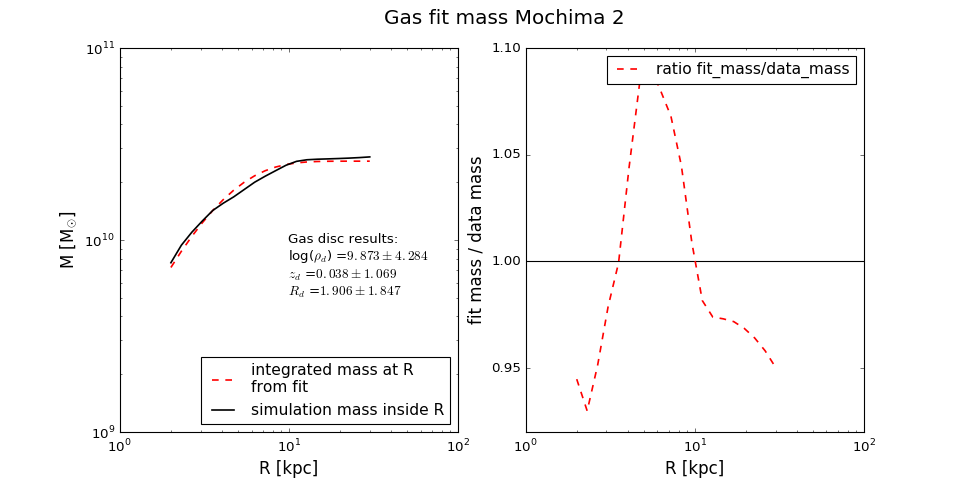

In [57]:
texto = "Gas disc results: \n"
texto += r"log($\rho _d$) =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["d0"],mmass_gs.errors["d0"])+"\n"
texto += r"$z_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["zs"],mmass_gs.errors["zs"])+"\n"
texto += r"$R_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["r0"],mmass_gs.errors["r0"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Mochima 2",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses, gas_fit_from_mass ,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses, gas_fit_from_mass/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [53]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "####################  GAS #########################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
####################  GAS #########################
Gas disc results: 
log($\rho _d$) =$ 9.823 \pm 4.225$
$z_d$ =$ 0.029 \pm 1.118$
$R_d$ =$ 2.810 \pm 2.503$



In [19]:
bins = gs_bins -1


edge = 20
zedge = edge/40.
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)


x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x_gs, y_gs)


"""
Z = gas(U[0],U[1],9.3, 0.2 , 1.2)
"""
#"""
Z = gas(U[0],U[1],mg2.values['D_0'], 0.5 , mg2.values['Rd'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


Z = gas(U[0],U[1],8.5, 0.1 , 2.)

fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist_gs.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist_gs)/dens_hist_gs

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

<IPython.core.display.Javascript object>

NameError: name 'xedges' is not defined

# COMPARISON

<IPython.core.display.Javascript object>


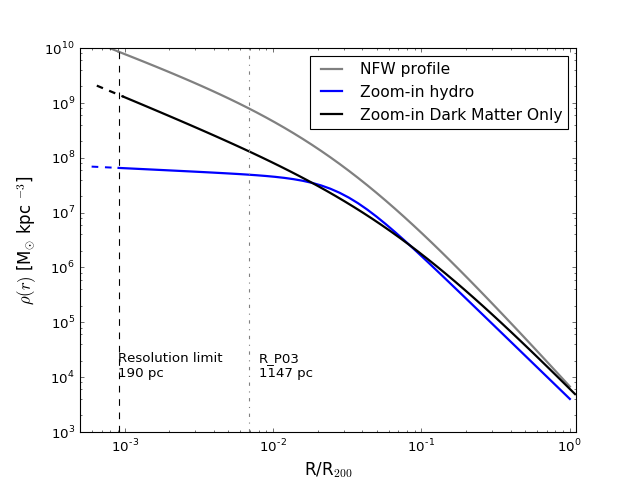

In [366]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.0005,1.1])
ax.set_ylim([1e3,1e10])
ax.set_xlabel(r'R/R$_{200}$',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
r_in = np.logspace(-1,np.log10(myhydro.gs.hsml.min()))
r_out = np.logspace(np.log10(myhydro.gs.hsml.min()),np.log10(myhydro.r200))
##NFW
ax.plot(r_in/myhydro.r200,(abg_profile(r_in,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=2,label="NFW profile")

## Hydro

ax.plot(r_in/myhydro.r200,(abg_profile(r_in,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b--",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b-",lw=2,label = "Zoom-in hydro")
#DMO
ax.plot(r_in/myDMO.r200,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k--",lw=2)
ax.plot(r_out/myDMO.r200,(abg_profile(r_out,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-",lw=2,label = "Zoom-in Dark Matter Only")
ax.axvline(myhydro.gs.hsml.min()/myhydro.r200,color="k",linestyle="--")
ax.text(9e-4,1e4,"Resolution limit\n190 pc")
ax.axvline(R_P03/myhydro.r200,color="gray",linestyle="-.")
ax.text(8e-3,1e4,"R_P03\n{0} pc".format(int(R_P03*1e3)))

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [368]:
def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)
get_maxw = np.vectorize(maxw)

v= np.linspace(0,600,100)
maxw = get_maxw(v,220/np.sqrt(2))
N = simps(maxw,v)
maxw = maxw/N

maxw2 = get_maxw(v,278/np.sqrt(2))
N = simps(maxw2,v)
maxw2 = maxw2/N

maxw3 = get_maxw(v,180/np.sqrt(2))
N = simps(maxw3,v)
maxw3 = maxw3/N

dmo_sun = (myDMO.dm.r>7.5)&(myDMO.dm.r<8.5)
hyd_sun = (myhydro.dm.r>7.5)&(myhydro.dm.r<8.5) 
fdv_dmo,bin_dmo = np.histogram(myDMO.dm.v[dmo_sun],bins=90,normed=True) 
fdv_hyd,bin_hyd = np.histogram(myhydro.dm.v[hyd_sun],bins=90,normed=True) 

<IPython.core.display.Javascript object>


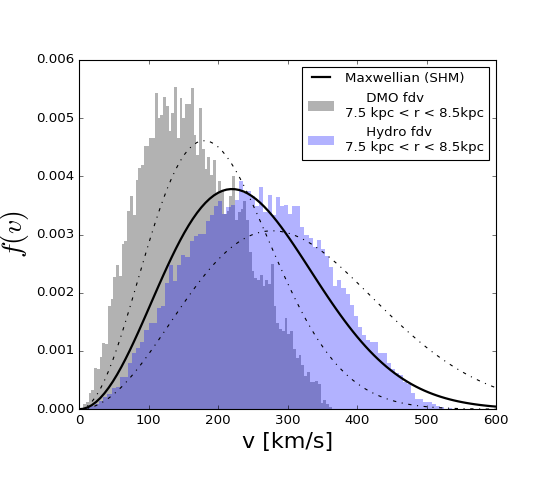

In [369]:

fig, ax = plt.subplots(figsize=[7,6])
plt.tight_layout(pad=4)
v= np.linspace(0,600,100)
ax.set_xlabel("v [km/s]",fontsize=20)
ax.set_ylabel(r"$f(v)$",fontsize=25)

ax.plot(v,maxw,"k",lw=2,label="Maxwellian (SHM)")
ax.plot(v,maxw2,"k-.",alpha=1)
ax.plot(v,maxw3,"k-.",alpha=1)

ax.bar((bin_dmo[:-1]+bin_dmo[1:])/2,fdv_dmo,width=bin_dmo[1]-bin_dmo[0],
       linewidth=0,color="k", alpha=0.3,label="     DMO fdv\n7.5 kpc < r < 8.5kpc")
ax.bar((bin_hyd[:-1]+bin_hyd[1:])/2,fdv_hyd,width=bin_hyd[1]-bin_hyd[0],
       linewidth=0,color="b", alpha=0.3,label="     Hydro fdv\n7.5 kpc < r < 8.5kpc")
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)
frame = legend.get_frame()